In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter # Para formatear los ejes
import seaborn as sb

### Carga de datos

In [2]:
# Visualiza las 23 columnas
pd.set_option('display.max_columns', 23)
# Carga del CSV en un DataFrame df (usando como delimitador la coma ',')
df = pd.read_csv('train.csv')

Para los datos renombrados y reordenados se va a usar el DataFrame dfok.

In [3]:
# Se renombran las columnas
nombresNuevos = {
                 'id' : 'ID',
                 'titulo' : 'Titulo',
                 'descripcion' : 'Descripcion',
                 'tipodepropiedad' : 'TipoPropiedad',
                 'direccion' : 'Direccion',
                 'ciudad' : 'Ciudad',
                 'provincia' : 'Provincia',
                 'antiguedad' : 'Antiguedad',
                 'habitaciones' : 'CantHabitaciones',
                 'garages' : 'CantGarages',
                 'banos' : 'CantBanos',
                 'metroscubiertos' : 'MetrosCuadradosCubiertos',
                 'metrostotales' : 'MetrosCuadradosTotales',
                 'idzona' : 'IDZona',
                 'lat' : 'Latitud',
                 'lng' : 'Longitud',
                 'fecha' : 'Fecha',
                 'gimnasio' : 'TieneGimnasio',
                 'usosmultiples' : 'TieneUsosMultiples',
                 'piscina' : 'TienePileta',
                 'escuelascercanas' : 'TieneEscuelasCerca',
                 'centroscomercialescercanos' : 'TieneShoppingsCerca',
                 'precio' : 'Precio'
                
}
dfok = df.rename(columns = nombresNuevos)

In [4]:
# Se Reordenan las columnas
nombresEnOrden = [
                 'ID',
                 'Titulo',
                 'TipoPropiedad',
                 'Precio',
                 'Fecha',
                 'Antiguedad',
                 'MetrosCuadradosCubiertos',
                 'MetrosCuadradosTotales',
                 'Descripcion',
                 
                 'CantHabitaciones',
                 'CantGarages',
                 'CantBanos',
               
                 'IDZona',
                 'Direccion',
                 'Ciudad',
                 'Provincia',
                 'Latitud',
                 'Longitud',
                 
                 'TieneGimnasio',
                 'TieneUsosMultiples',
                 'TienePileta',
                 'TieneEscuelasCerca',
                 'TieneShoppingsCerca'
    ]                 
dfok = dfok[nombresEnOrden];

### Análisis de propiedades por sus comodidades

Se va a analizar la relación entre la provincia y la cantidad de tipos de comodidad de las propiedades.

In [5]:
columnas = ['Ciudad',
            'Provincia',
            'TieneGimnasio',
            'TieneUsosMultiples',
            'TienePileta',
            'TieneEscuelasCerca',
            'TieneShoppingsCerca',
            'Precio'] 

En el análisis exploratorio de Navent se indica que los nombres de ciudades y provincias son String, el precio se representa con tipo entero y las demás columnas de comodidades son Booleanas. 

Se crea un nuevo DataFrame df_abool que copia columnas de interés del DataFrame original.

In [6]:
df_abool = dfok[columnas].copy()
memoria_usada = df_abool.memory_usage()
print('Total memoria usada sin cambios de tipos {:.2f}'.format(memoria_usada.sum()/1024/1024), 'MB')

Total memoria usada sin cambios de tipos 14.65 MB


Se convierten los tipos de datos

In [7]:
df_abool['TieneGimnasio'] = df_abool['TieneGimnasio'].astype(np.bool)
df_abool['TieneUsosMultiples'] = df_abool['TieneUsosMultiples'].astype(np.bool)
df_abool['TienePileta'] = df_abool['TienePileta'].astype(np.bool)
df_abool['TieneEscuelasCerca'] = df_abool['TieneEscuelasCerca'].astype(np.bool)
df_abool['TieneShoppingsCerca'] = df_abool['TieneShoppingsCerca'].astype(np.bool)
df_abool['Precio'] = df_abool['Precio'].astype(np.uint32)
df_abool['Ciudad'] = df_abool['Ciudad'].astype('category')
df_abool['Provincia'] = df_abool['Provincia'].astype('category')
print('Total memoria usada con cambios de tipos {0:.2f}'.format(df_abool.memory_usage().sum()/1024/1024), 'MB')

Total memoria usada con cambios de tipos 2.79 MB


### Análisis de calidad de datos

In [8]:
df_abool.isnull().sum()

Ciudad                 372
Provincia              155
TieneGimnasio            0
TieneUsosMultiples       0
TienePileta              0
TieneEscuelasCerca       0
TieneShoppingsCerca      0
Precio                   0
dtype: int64

Aparecen valores nulos en las columnas Ciudad y Provincia. Se verifica si hay alguna relación entre los valores nulos de provincias y ciudades. Para esto se ubican los casos en que ambos son nulos.

In [9]:
df_abool[(df_abool['Ciudad'].isnull() == True) & (df_abool['Provincia'].isnull() == True)].isnull().sum()

Ciudad                 155
Provincia              155
TieneGimnasio            0
TieneUsosMultiples       0
TienePileta              0
TieneEscuelasCerca       0
TieneShoppingsCerca      0
Precio                   0
dtype: int64

Antes se tenía 155 casos de Provincia nulos, pero aquí se ve que ésos valores también tienen ciudades nulas. Como se van utilizar estos valores conviene descartarlos.

In [10]:
df_abool.dropna(subset=['Provincia'], inplace=True)
df_abool.isnull().sum()

Ciudad                 217
Provincia                0
TieneGimnasio            0
TieneUsosMultiples       0
TienePileta              0
TieneEscuelasCerca       0
TieneShoppingsCerca      0
Precio                   0
dtype: int64

A continuación se verifica qué proporción de valores nulos de ciudades por provincia queda, para ver si es correcto eliminarlas.

In [11]:
# Se crea un DataFrame donde solo se almacenan los casos con valores nulos de ciudades
cant_nulos_provincia = df_abool.loc[df_abool['Ciudad'].isnull() == True].copy() # Devuelve un DataFrame
# Se elije solo la columna Provincia y se realiza un conteo. Devuelve una Serie
cant_nulos_provincia = cant_nulos_provincia['Provincia'].value_counts() # Devuelve una Serie
# Se transforma la Serie a DataFrame
cant_nulos_provincia = cant_nulos_provincia.to_frame()
# Se resetea el índice para tener una columna con el nombre de las provincias
cant_nulos_provincia.reset_index(inplace = True)
# Se cambia el nombre a la columna de las provincias
cant_nulos_provincia.rename(columns = {'index' : 'Provincia', 'Provincia' : 'cant_nulos'}, inplace = True)
# Se ordena alfabéticamente por nombre de provincia
cant_nulos_provincia.sort_values(by='Provincia', ascending = True, inplace = True)
cant_nulos_provincia.reset_index(drop = True, inplace=True)

Con esto se tiene un DataFrame con una columna con los nombres de las provincias y otra con la cantidad correspondiente de ciudades nulas.

Luego se crea un DataFrame con la cantidad total de casos por provincia, que luego que compara con los casos nulos.

In [12]:
cant_total_provincia = df_abool['Provincia'] # Devuelve una Serie
# Se convierto a DataFrame
cant_total_provincia = cant_total_provincia.value_counts().to_frame()
# Se resetea el índice para tener una columna con el nombre de las provincias
cant_total_provincia.reset_index(inplace = True)
# Se cambia el nombre a la columna de las provincias
cant_total_provincia.rename(columns = {'index' : 'Provincia', 'Provincia' : 'cant_total'}, inplace = True)
# Se ordena alfabéticamente por nombre de provincia
cant_total_provincia.sort_values(by = 'Provincia', ascending = True, inplace = True)
cant_total_provincia.reset_index(drop = True, inplace = True)

El DataFrame `cant_total_provincia` tiene una columna con los nombres de las provincias y otra con la cantidad total de provincias.

### Merge de cant_nulos_provincia con cant_total_provincia

1. DataFrame izquierdo `cant_nulos_provincia`
- DataFrame derecho `cant_total_provincia`

La unión se realiza sobre la columna Provincia.

In [13]:
df_joined = pd.merge(cant_nulos_provincia, cant_total_provincia, on='Provincia', how = 'inner')

Como en cant_nulos_provincia había ceros (casos de provincias sin valores nulos), se seleccionan solo los casos distintos de cero. Recordar que se quiere eliminar los nulos.

In [14]:
df_joined = df_joined.loc[df_joined['cant_nulos'] != 0].copy()
df_joined.reset_index(drop = True, inplace = True)
# Ya se tiene un DataFrame para calcular la proporción de los valores nulos en los totales (por provincia)

Ahora se agrega una columna de proporciones.

In [15]:
df_joined['propor_nulos [%]'] = df_joined['cant_nulos'] / df_joined['cant_total'] * 100
# Se redondea a dos decimales
df_joined['propor_nulos [%]'] = df_joined['propor_nulos [%]'].round(2)
df_joined

,Provincia,cant_nulos,cant_total,propor_nulos [%]
0,Chihuahua,46,4590,1.00
1,Distrito Federal,20,58790,0.03
2,Durango,1,2275,0.04
3,Edo. de México,18,41607,0.04
4,Guanajuato,3,2860,0.10
5,Guerrero,3,2678,0.11
6,Jalisco,21,21238,0.10
7,Morelos,2,7337,0.03
8,Nuevo León,9,15324,0.06
9,Oaxaca,3,711,0.42


Se ve que no representan más del 1% de los casos totales. Enonces se pueden eliminar.

In [16]:
df_abool.dropna(inplace = True)

Ahora se tiene df_abool sin casos nulos.

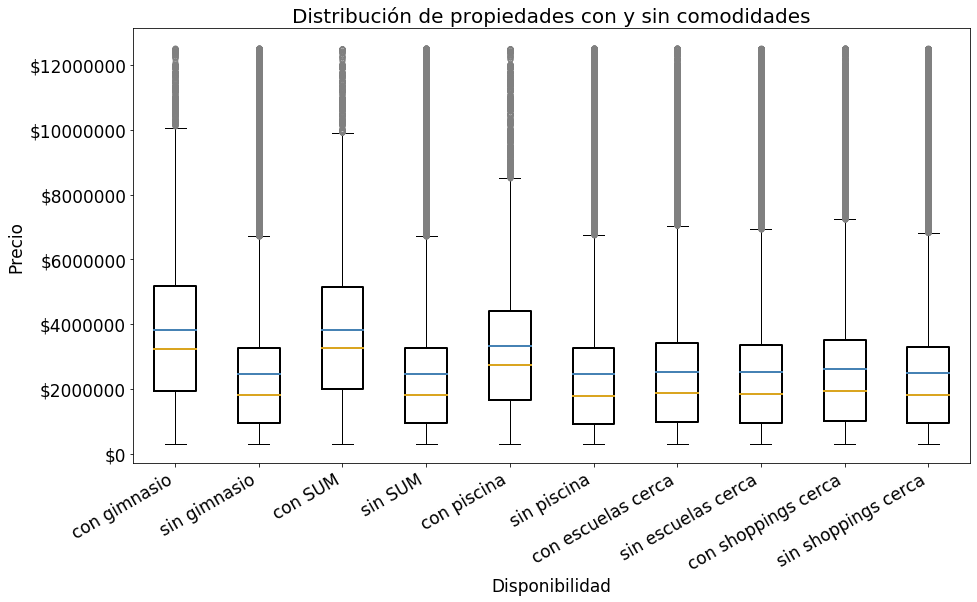

In [17]:
plt.figure(figsize = (15,8))
plt.xticks(fontsize = 17, rotation = 30, ha = 'right')
plt.yticks(fontsize = 17)
plt.title("Distribución de propiedades con y sin comodidades", fontsize = 20)
plot = plt.boxplot([df_abool.loc[df_abool['TieneGimnasio'] == True]['Precio'], \
                    df_abool.loc[df_abool['TieneGimnasio'] == False]['Precio'], \
                    df_abool.loc[df_abool['TieneUsosMultiples'] == True]['Precio'], \
                    df_abool.loc[df_abool['TieneUsosMultiples'] == False]['Precio'], \
                    df_abool.loc[df_abool['TienePileta'] == True]['Precio'], \
                    df_abool.loc[df_abool['TienePileta'] == False]['Precio'], \
                    df_abool.loc[df_abool['TieneEscuelasCerca'] == True]['Precio'], \
                    df_abool.loc[df_abool['TieneEscuelasCerca'] == False]['Precio'], \
                    df_abool.loc[df_abool['TieneShoppingsCerca'] == True]['Precio'], \
                    df_abool.loc[df_abool['TieneShoppingsCerca'] == False]['Precio']], 
                   labels = ['con gimnasio', 'sin gimnasio', \
                             'con SUM', 'sin SUM', \
                             'con piscina', 'sin piscina', \
                             'con escuelas cerca', 'sin escuelas cerca', \
                             'con shoppings cerca', 'sin shoppings cerca'],
                   widths = 0.5, \
                   meanline = True, showmeans=True, \
                   boxprops = dict(linewidth=2), \
                   meanprops = dict(linestyle = '-', linewidth=2, color = 'steelblue'), \
                   # linestyle = '-' muestra la media con línea sólida
                   flierprops = dict(marker='o', markerfacecolor='none', markersize=5, \
                                     linestyle='none', markeredgecolor = 'grey'), \
                   medianprops = dict(linestyle = '-', linewidth=2, color='goldenrod'))
plt.xlabel('Disponibilidad', fontsize = 17)
plt.ylabel('Precio', fontsize = 17)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.show()

Observando las comodidades propias de las propiedades (gimnasio, Salón de usos múltiples y piscina), se nota que los precios aumentan, lo que es esperable. La cercanía a comodidades compartidas (escuelas y centros comerciales) no modifica el valor medio del precio de las propiedades.

A continuación solo se visualiza las dispersión de los casos con comodidades. Se muestran el valor medio, la mediana y el rango entre el primer y tercer cuartil.

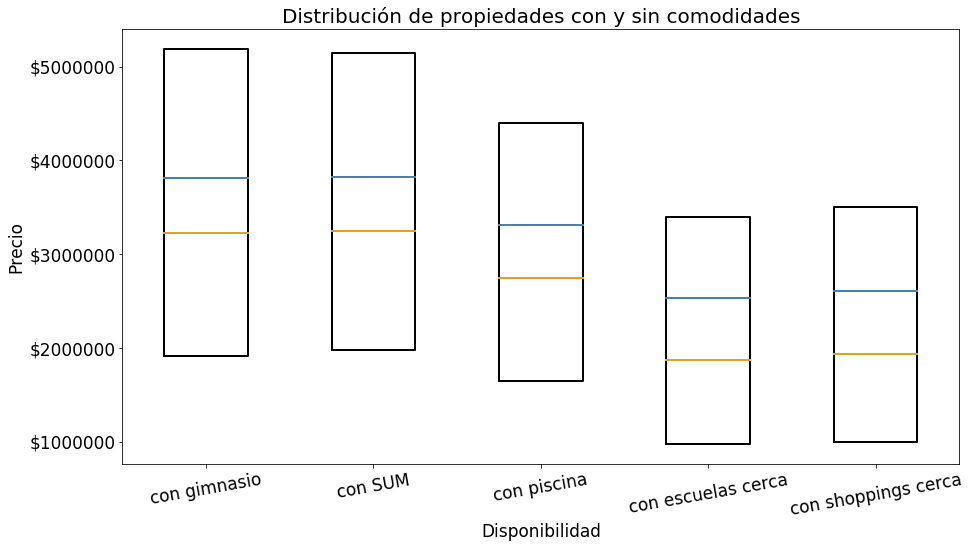

In [18]:
plt.figure(figsize = (15,8))
plt.xticks(fontsize = 17, rotation = 10, ha = 'center')
plt.yticks(fontsize = 17)
plt.title("Distribución de propiedades con y sin comodidades", fontsize = 20)
plot = plt.boxplot([df_abool.loc[df_abool['TieneGimnasio'] == True]['Precio'], \
                    df_abool.loc[df_abool['TieneUsosMultiples'] == True]['Precio'], \
                    df_abool.loc[df_abool['TienePileta'] == True]['Precio'], \
                    df_abool.loc[df_abool['TieneEscuelasCerca'] == True]['Precio'], \
                    df_abool.loc[df_abool['TieneShoppingsCerca'] == True]['Precio']], \
                   labels = ['con gimnasio', \
                             'con SUM', \
                             'con piscina', \
                             'con escuelas cerca', \
                             'con shoppings cerca'],
                   widths = 0.5, \
                   whis = 0, \
                   showfliers = False, \
                   meanline = True, showmeans=True, \
                   boxprops = dict(linewidth=2), \
                   meanprops = dict(linestyle = '-', linewidth=2, color = 'steelblue'), \
                   # linestyle = '-' muestra la media con línea sólida
                   flierprops = dict(marker='o', markerfacecolor='none', markersize=5, \
                                     linestyle='none', markeredgecolor = 'grey'), \
                   medianprops = dict(linestyle = '-', linewidth=2, color='goldenrod'))
plt.xlabel('Disponibilidad', fontsize = 17)
plt.ylabel('Precio', fontsize = 17)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.show()

A continuación se analiza cuántos casos hay con comodidades de manera exclusiva. Las escuelas y los centros comerciales son amenidades compartidas con diversas propiedades.

In [19]:
# Se arman DataFrames con comodidades exclusivas para las propiedades.
solo_gimnasio = df_abool.loc[(df_abool['TieneGimnasio'] == True) & 
                             (df_abool['TieneUsosMultiples'] == False) & 
                             (df_abool['TienePileta'] == False)].copy()

solo_sum = df_abool.loc[(df_abool['TieneGimnasio'] == False) & 
                        (df_abool['TieneUsosMultiples'] == True) & 
                        (df_abool['TienePileta'] == False)].copy()

solo_piscina = df_abool.loc[(df_abool['TieneGimnasio'] == False) & 
                            (df_abool['TieneUsosMultiples'] == False) & 
                            (df_abool['TienePileta'] == True)].copy()

In [20]:
print('Solo con gimnasio:', len(solo_gimnasio), \
      '\nSolo con salón de usos múltiples:', len(solo_sum), \
      '\nSolo con piscina:', len(solo_piscina))
proporcion = (len(solo_gimnasio) + len(solo_sum) + len(solo_piscina))*100/240000
print('Proporción de estos casos respecto del total:', round(proporcion,2), '%')

Solo con gimnasio: 5614 
Solo con salón de usos múltiples: 4987 
Solo con piscina: 11690
Proporción de estos casos respecto del total: 9.29 %


Son pocos casos

In [21]:
# Solo con SUM

print('Media del precio de las propiedades con solo Gimnasio $ {:.0f}'
      .format(solo_gimnasio['Precio'].mean()))

print('Media del precio de las propiedades con solo SUM $ {:.0f}'
      .format(solo_sum['Precio'].mean()))

print('Media del precio de las propiedades con solo Piscina $ {:.0f}'
      .format(solo_piscina['Precio'].mean()))

Media del precio de las propiedades con solo Gimnasio $ 3056434
Media del precio de las propiedades con solo SUM $ 3593696
Media del precio de las propiedades con solo Piscina $ 2719016


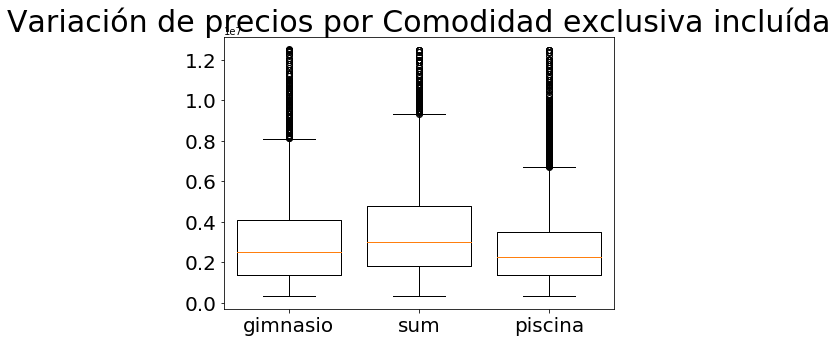

In [22]:
# Análisis por exclusión de las distintas comodidades
plt.figure(figsize = (7,5))
plt.xticks(rotation = 0, fontsize = 20)
plt.yticks(fontsize = 20)
# Para formatear los ejes
#sub_fig.yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.title("Variación de precios por Comodidad exclusiva incluída", fontsize = 30)
box_plot = plt.boxplot([solo_gimnasio['Precio'], solo_sum['Precio'], solo_piscina['Precio']], \
                       labels = ['gimnasio', 'sum','piscina'], \
                       widths = 0.8)

### Primero armo una lista de nombres de las provincias ordenadas por la media del precio de las propiedades

In [23]:
propiedades_valores = df_abool[['Provincia', 'Precio']].copy()

In [24]:
# Se verifica si hay valores nulos
print(propiedades_valores.isnull().sum())

Provincia    0
Precio       0
dtype: int64


In [25]:
propiedades_valores = propiedades_valores.groupby(['Provincia']).agg({'Precio':'mean'}).copy()
# Se le cambia el nombre a la columna
propiedades_valores.rename(columns = {'Precio' : 'Media Precio'}, inplace=True)
# Se le cambia el tipo a la columna
propiedades_valores['Media Precio'] = propiedades_valores['Media Precio'].astype(np.uint32).copy()
propiedades_valores.head(1)

,Media Precio
Provincia,
Aguascalientes,1477188


In [26]:
# Ordeno de mayor a menor por Media de precio
propiedades_valores = propiedades_valores.sort_values(by='Media Precio', ascending = False)
propiedades_valores.head()

,Media Precio
Provincia,
Distrito Federal,3471126
Edo. de México,2762169
Nuevo León,2715694
Guerrero,2550175
Quintana Roo,2402542


In [27]:
# Arreglo los índices
propiedades_valores.reset_index(inplace=True)
propiedades_valores.head()

,Provincia,Media Precio
0,Distrito Federal,3471126
1,Edo. de México,2762169
2,Nuevo León,2715694
3,Guerrero,2550175
4,Quintana Roo,2402542


In [28]:
# Se arma una lista con los nombres de las provincias en orden alfabético
provincias_nombres = propiedades_valores['Provincia'].unique()
provincias_nombres = list(provincias_nombres) # Convierte nunpy.array en lista

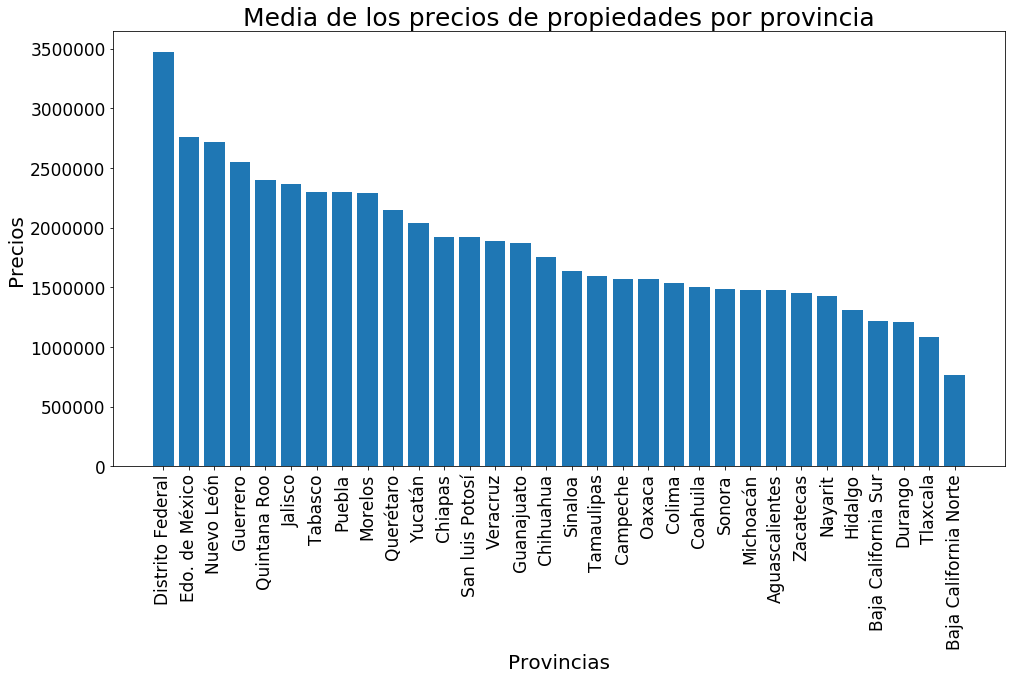

In [29]:
# Gráfico de media de precio por provincia
indice = propiedades_valores['Provincia']
media = propiedades_valores['Media Precio']
ancho = 0.8

plt.figure(figsize = (16,8))
plt.bar(indice, media, ancho)
plt.title("Media de los precios de propiedades por provincia", fontsize = 25)
plt.ylabel('Precios', fontsize = 20)
plt.xlabel('Provincias', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 17)
plt.yticks(fontsize = 17)
plt.show()

In [30]:
# Ahora con solo gimnasios

# Se crea una lista de los nombres de las provincias ordenados de mayor a menor por la media
provincias_nombres = solo_gimnasio\
    .groupby(['Provincia'])\
    .agg({'Precio' : 'mean'})\
    .sort_values(by = 'Precio', ascending = False)
provincias_nombres.rename(columns = {'Precio' : 'Media'}, inplace = True) # Se renombra por claridad
provincias_nombres['Media'] = provincias_nombres['Media'].astype(np.uint32)
provincias_nombres.reset_index(inplace = True)
provincias_nombres = provincias_nombres['Provincia'].unique() 
# Lo anterior devuelve una arrary de categóricos en el orden que aparecen. Se convierte en lista.
provincias_nombres = list(provincias_nombres)

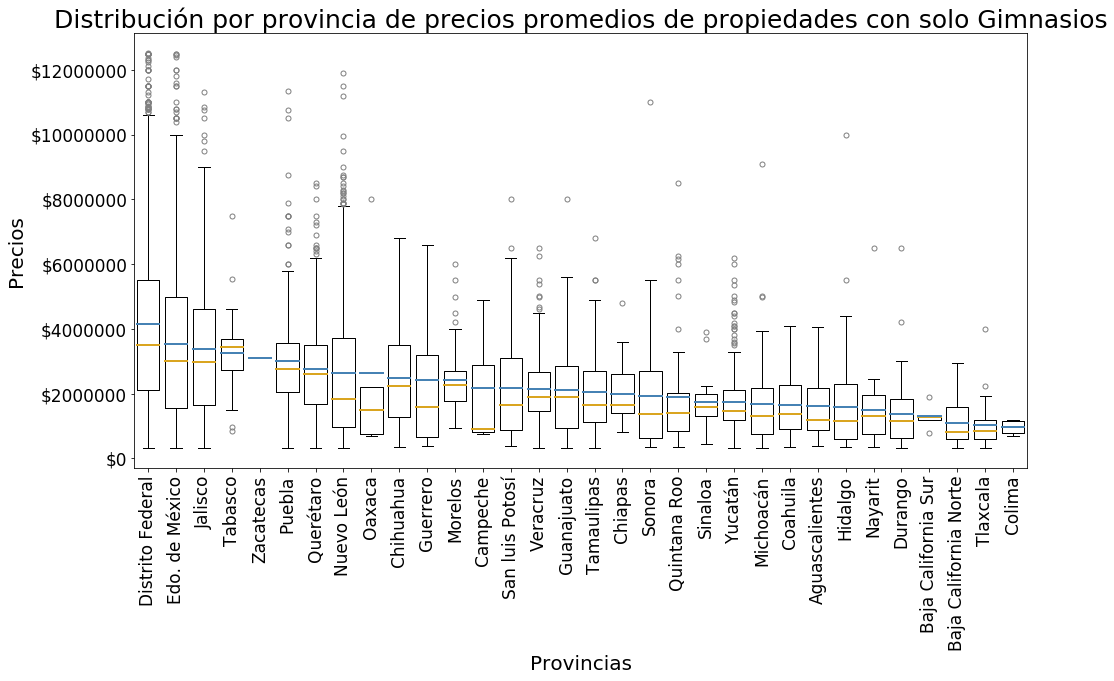

In [31]:
# Gráfico para solo propiedades con gimnasio (exclusivamente)

plt.figure(figsize = (16,8))
plt.boxplot([solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[0]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[1]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[2]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[3]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[4]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[5]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[6]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[7]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[8]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[9]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[10]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[11]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[12]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[13]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[14]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[15]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[16]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[17]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[18]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[19]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[20]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[21]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[22]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[23]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[24]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[25]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[26]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[27]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[28]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[29]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[30]]['Precio'], \
             solo_gimnasio.loc[solo_gimnasio['Provincia'] == provincias_nombres[31]]['Precio']], \
            labels = provincias_nombres, \
            widths = 0.8, \
            meanline = True, showmeans = True, \
            boxprops = dict(linewidth=1), \
            meanprops = dict(linestyle = '-', linewidth=2, color = 'steelblue'), \
            # linestyle = '-' muestra la media con línea sólida
            flierprops = dict(marker='o', markerfacecolor='none', markersize=5, linestyle='none', markeredgecolor = 'grey'), \
            medianprops = dict(linestyle = '-', linewidth=2, color='goldenrod'))
plt.title("Distribución por provincia de precios promedios de propiedades con solo Gimnasios", fontsize = 25)
plt.ylabel('Precios', fontsize = 20)
plt.xlabel('Provincias', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 17)
plt.yticks(fontsize = 17)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.show()

In [32]:
# Ahora con solo SUM

# Se crea una lista de los nombres de las provincias ordenados de mayor a menor por la media
provincias_nombres = solo_sum\
    .groupby(['Provincia'])\
    .agg({'Precio' : 'mean'})\
    .sort_values(by = 'Precio', ascending = False)
provincias_nombres.rename(columns = {'Precio' : 'Media'}, inplace = True) # Se renombra por claridad
provincias_nombres['Media'] = provincias_nombres['Media'].astype(np.uint32)
provincias_nombres.reset_index(inplace = True)
provincias_nombres = provincias_nombres['Provincia'].unique() 
# Lo anterior devuelve una arrary de categóricos en el orden que aparecen. Se convierte en lista.
provincias_nombres = list(provincias_nombres) 

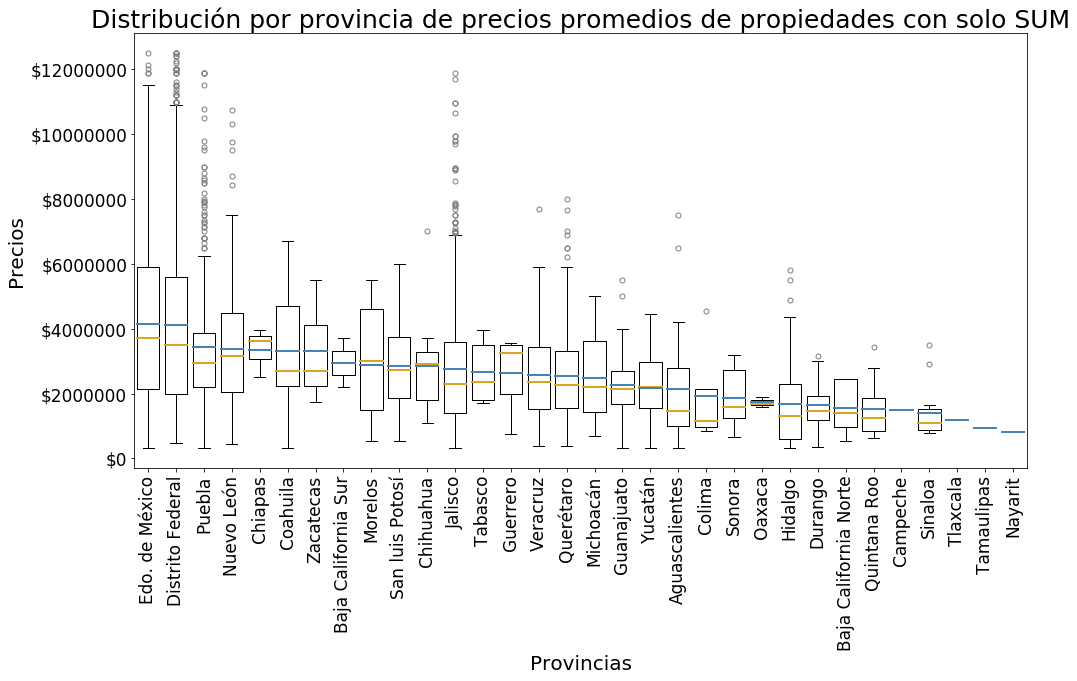

In [33]:
# Gráfico para solo propiedades con Salón de Usos Múltiples (exclusivamente)

plt.figure(figsize = (16,8))
plt.boxplot([solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[0]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[1]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[2]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[3]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[4]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[5]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[6]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[7]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[8]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[9]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[10]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[11]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[12]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[13]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[14]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[15]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[16]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[17]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[18]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[19]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[20]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[21]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[22]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[23]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[24]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[25]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[26]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[27]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[28]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[29]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[30]]['Precio'], \
             solo_sum.loc[solo_sum['Provincia'] == provincias_nombres[31]]['Precio']], \
            labels = provincias_nombres, \
            widths = 0.8, \
            meanline = True, showmeans = True, \
            boxprops = dict(linewidth=1), \
            meanprops = dict(linestyle = '-', linewidth=2, color = 'steelblue'), \
            # linestyle = '-' muestra la media con línea sólida
            flierprops = dict(marker='o', markerfacecolor='none', markersize=5, linestyle='none', markeredgecolor = 'grey'), \
            medianprops = dict(linestyle = '-', linewidth=2, color='goldenrod'))
plt.title('Distribución por provincia de precios promedios de propiedades con solo SUM', fontsize = 25)
plt.ylabel('Precios', fontsize = 20)
plt.xlabel('Provincias', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 17)
plt.yticks(fontsize = 17)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.show()

In [34]:
# Ahora con solo Piletas

# Se crea una lista de los nombres de las provincias ordenados de mayor a menor por la media
provincias_nombres = solo_piscina\
    .groupby(['Provincia'])\
    .agg({'Precio' : 'mean'})\
    .sort_values(by = 'Precio', ascending = False)
provincias_nombres.rename(columns = {'Precio' : 'Media'}, inplace = True)
# Se eliminan los multiíndices
provincias_nombres.reset_index(inplace = True)
# Se cambia el tipo de la columna Media
provincias_nombres['Media'] = provincias_nombres['Media'].astype(np.float32)
# Se verifica si hay casos nulos
provincias_nombres.loc[provincias_nombres['Media'].isnull() == True]['Provincia']
# Hay un caso nulo: Zacatecas 

31    Zacatecas
Name: Provincia, dtype: category
Categories (32, object): [Aguascalientes, Baja California Norte, Baja California Sur, Campeche, ..., Tlaxcala, Veracruz, Yucatán, Zacatecas]

In [35]:
print(dfok.loc[dfok['Provincia'] == 'Zacatecas']['TienePileta'].value_counts())

0.0    94
Name: TienePileta, dtype: int64


Un análisis general del DataFrame dfok muestra que solo hay 0.0 ("Falso") en el conteo de casos para la provincia Zacatecas. Esto es que ninguna propiedad tiene pileta en Zacatecas.

In [36]:
# Se elimina la fila con nulos
provincias_nombres.dropna(inplace = True)
provincias_nombres['Media'] = provincias_nombres['Media'].astype(np.uint32)
provincias_nombres.reset_index(inplace = True)
provincias_nombres = provincias_nombres['Provincia'].unique()
# Lo anterior devuelve una arrary de categóricos en el orden que aparecen. Se convierte en lista.
provincias_nombres = list(provincias_nombres)
# Ahora la lista de nombres de provincias no tiene casos nulos

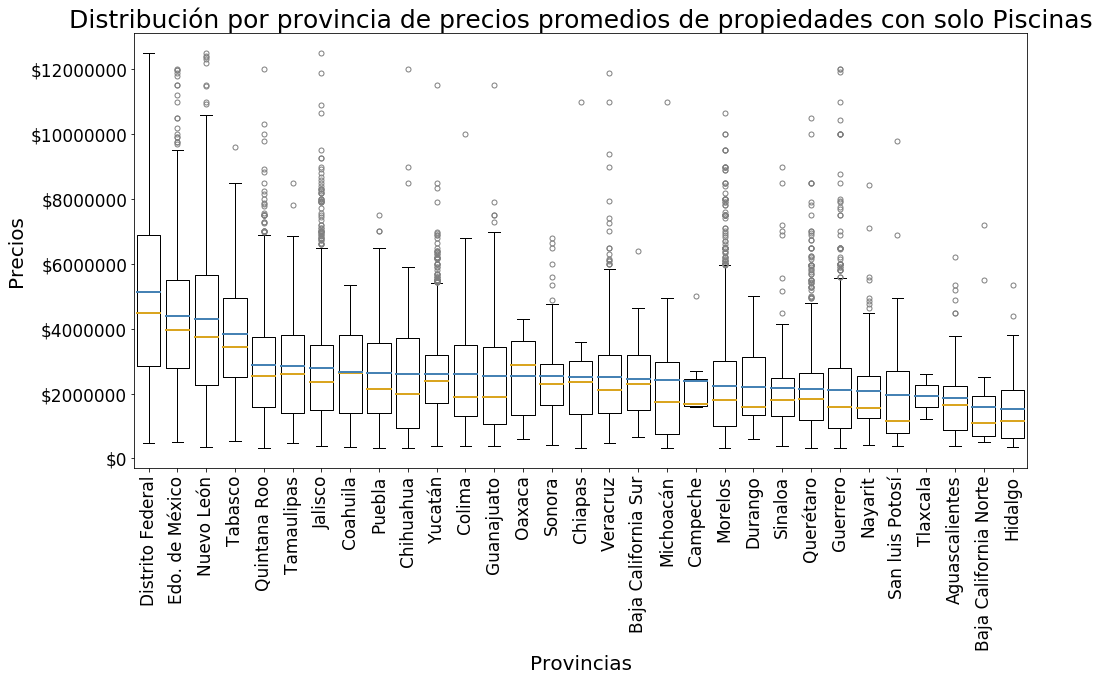

In [37]:
# Gráfico para solo propiedades con Pileta (exclusivamente)

plt.figure(figsize = (16,8))
plt.boxplot([solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[0]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[1]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[2]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[3]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[4]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[5]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[6]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[7]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[8]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[9]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[10]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[11]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[12]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[13]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[14]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[15]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[16]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[17]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[18]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[19]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[20]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[21]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[22]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[23]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[24]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[25]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[26]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[27]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[28]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[29]]['Precio'], \
             solo_piscina.loc[solo_piscina['Provincia'] == provincias_nombres[30]]['Precio']], \
            labels = provincias_nombres, \
            widths = 0.8, \
            meanline = True, showmeans = True, \
            boxprops = dict(linewidth=1), \
            meanprops = dict(linestyle = '-', linewidth=2, color = 'steelblue'), \
            # linestyle = '-' muestra la media con línea sólida
            flierprops = dict(marker='o', markerfacecolor='none', markersize=5, linestyle='none', markeredgecolor = 'grey'), \
            medianprops = dict(linestyle = '-', linewidth=2, color='goldenrod'))
plt.title("Distribución por provincia de precios promedios de propiedades con solo Piscinas", fontsize = 25)
plt.ylabel('Precios', fontsize = 20)
plt.xlabel('Provincias', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 17)
plt.yticks(fontsize = 17)
#plt.gca().yaxis.set_major_formatter(PercentFormatter(decimals=2))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.show()

# Análisis de tipo de comodidad a medida que pasan los años

In [38]:
# Se usa df_ok para las columnas porque tiene números en las columnas, sirve para contar.
df_comodidad = dfok[['TieneGimnasio', \
                     'TieneUsosMultiples', \
                     'TienePileta', \
                     'TieneEscuelasCerca', \
                     'TieneShoppingsCerca']]
# Aquí se usa dfok pues tiene la columna 'Antiguedad'
df_comodidad.insert(0, 'Antiguedad', dfok['Antiguedad'])

### Analizo si hay nulos

In [39]:
print(df_comodidad.isnull().sum())
memoria_usada = df_comodidad.memory_usage().sum()/(1024*1024)
print('Memoria usada', memoria_usada.round(2), "MB")

Antiguedad             43555
TieneGimnasio              0
TieneUsosMultiples         0
TienePileta                0
TieneEscuelasCerca         0
TieneShoppingsCerca        0
dtype: int64
Memoria usada 10.99 MB


Hay 43555 casos nulos y es necesario rmoverlos para covertir los tipos. Hasta aquí los tipos del DataFrame df_comodidad son float64.

In [40]:
# Elimino las filas nulas, para así poder realizar las conversión de tipos.
# Además, para este análisis es necesario un valor en la columna 'Antiguedad'.
df_comodidad = df_comodidad.dropna().copy()
df_comodidad.reset_index(drop = True, inplace = True)
df_comodidad.dtypes

Antiguedad             float64
TieneGimnasio          float64
TieneUsosMultiples     float64
TienePileta            float64
TieneEscuelasCerca     float64
TieneShoppingsCerca    float64
dtype: object

In [41]:
# Cambio los tipos del DataFrame
df_comodidad['Antiguedad'] = df_comodidad['Antiguedad'].astype(np.uint8)
df_comodidad['TieneGimnasio'] = df_comodidad['TieneGimnasio'].astype(np.uint8)
df_comodidad['TieneUsosMultiples'] = df_comodidad['TieneUsosMultiples'].astype(np.uint8)
df_comodidad['TienePileta'] = df_comodidad['TienePileta'].astype(np.uint8)
df_comodidad['TieneEscuelasCerca'] = df_comodidad['TieneEscuelasCerca'].astype(np.uint8)
df_comodidad['TieneShoppingsCerca'] = df_comodidad['TieneShoppingsCerca'].astype(np.uint8)
memoria_usada = df_comodidad.memory_usage().sum()/(1024*1024)
print('Memoria usada', memoria_usada.round(2), "MB")

Memoria usada 1.12 MB


Como se tienen 80 años para antigüedad, agregro una columna con rango de años.

In [42]:
# Se define una función de calcula el rango de años dónde cae la antigüedad de la propiedad
# Primero se elige un orden y luego se cambia el nombre de las filas.
# Esto es para evitar tener que insrtar una fila en medio del DataFrame
def rango_de_años(df):
    if df['Antiguedad'] <= 5: return '00'# '0 - 5'
    elif 6  <= df['Antiguedad'] <= 10: return '01'# '6 - 10'
    elif 11 <= df['Antiguedad'] <= 15: return '02'# '11 - 15'
    elif 16 <= df['Antiguedad'] <= 20: return '03'# '16 - 20'
    elif 21 <= df['Antiguedad'] <= 25: return '04'# '21 - 25'
    elif 26 <= df['Antiguedad'] <= 30: return '05'# '26 - 30'
    elif 31 <= df['Antiguedad'] <= 35: return '06'# '31 - 35'
    elif 36 <= df['Antiguedad'] <= 40: return '07'# '26 - 40'
    elif 41 <= df['Antiguedad'] <= 45: return '08'# '41 - 45'
    elif 46 <= df['Antiguedad'] <= 50: return '09'# '46 - 50'
    elif 51 <= df['Antiguedad'] <= 55: return '10'# '51 - 55'
    elif 56 <= df['Antiguedad'] <= 60: return '11'# '56 - 60'
    elif 61 <= df['Antiguedad'] <= 65: return '12'# '61 - 65'
    elif 66 <= df['Antiguedad'] <= 70: return '13'# '66 - 70'
    elif 71 <= df['Antiguedad'] <= 75: return '14'# '71 - 75'
    elif 76 <= df['Antiguedad'] <= 80: return '15'# '76 - 80'

In [43]:
# Auxiliar para asignar rango de años
df_aux = df_comodidad.apply(rango_de_años, axis = 1) # Devuelve una serie

In [44]:
# Se hace una copia para los agrupados
df_comodidad_agrupada5 = df_comodidad.copy()

In [45]:
# Se agrega la columna correspondiente al rango de años de antigüedad
df_comodidad_agrupada5['RangoDeAños'] = df_aux

In [46]:
# Se usa el auxiliar para agrupar por rango de años
df_aux = df_comodidad_agrupada5.groupby('RangoDeAños').agg({'TieneGimnasio':'sum', \
                                        'TieneUsosMultiples':'sum', \
                                        'TienePileta':'sum', \
                                        'TieneEscuelasCerca':'sum', \
                                        'TieneShoppingsCerca':'sum'})
# Aquí df_aux no toma en cuenta la columna Antigüedad

In [47]:
# Para tener una copia de los ya agrupados
df_comodidad_agrupada5 = df_aux.copy()

In [48]:
# Ahora se cambia el nombre de las filas del índice RangoDeAños
dictionary = {'00':'0 - 5', '01':'6 - 10', '02':'11 - 15', '03':'16 - 20', \
             '04':'21 - 25', '05':'26 - 30', '06':'31 - 35', '07':'36 - 40', \
             '08':'41 - 45', '09':'46 - 50', '10':'51 - 55', '11':'56 - 60', \
             '12':'61 - 65', '13':'66 - 70', '14':'71 - 75', '15':'76 - 80'}
df_comodidad_agrupada5.rename(dictionary, axis=0, inplace=True)

In [49]:
df_comodidad_agrupada5.memory_usage().sum()/1024/1024

0.000732421875

In [50]:
# Sumo columnas al final para tener el total por rango de años y se asigna a un nuevo DataFrame
total_comodidades = df_comodidad_agrupada5.sum(axis = 1)
dec = 3 # Para redondear
df_comodidad_proporciones5 = pd.DataFrame()
df_comodidad_proporciones5['Proporcion Gimnasio'] = \
        round(df_comodidad_agrupada5['TieneGimnasio'] / total_comodidades,dec)
df_comodidad_proporciones5['Proporcion UsosMultiples'] = \
        round(df_comodidad_agrupada5['TieneUsosMultiples'] / total_comodidades,dec)
df_comodidad_proporciones5['Proporcion Pileta'] = \
        round(df_comodidad_agrupada5['TienePileta'] / total_comodidades,dec)
df_comodidad_proporciones5['Proporcion EscuelasCerca'] = \
        round(df_comodidad_agrupada5['TieneEscuelasCerca'] / total_comodidades,dec)
df_comodidad_proporciones5['Proporcion ShoppingsCerca'] = \
        round(df_comodidad_agrupada5['TieneShoppingsCerca'] / total_comodidades,dec)
df_comodidad_proporciones5['Proporcion Propias'] = df_comodidad_proporciones5['Proporcion Gimnasio'] + \
                                                   df_comodidad_proporciones5['Proporcion UsosMultiples'] + \
                                                   df_comodidad_proporciones5['Proporcion Pileta']
df_comodidad_proporciones5['Proporcion Compartidas'] = df_comodidad_proporciones5['Proporcion EscuelasCerca'] + \
                                                       df_comodidad_proporciones5['Proporcion ShoppingsCerca']

In [51]:
df_comodidad_proporciones5

,Proporcion Gimnasio,Proporcion UsosMultiples,Proporcion Pileta,Proporcion EscuelasCerca,Proporcion ShoppingsCerca,Proporcion Propias,Proporcion Compartidas
RangoDeAños,,,,,,,
0 - 5,0.074,0.066,0.106,0.397,0.357,0.246,0.754
6 - 10,0.038,0.034,0.051,0.460,0.417,0.123,0.877
11 - 15,0.042,0.029,0.061,0.485,0.382,0.132,0.867
16 - 20,0.021,0.026,0.027,0.480,0.446,0.074,0.926
21 - 25,0.047,0.022,0.040,0.505,0.386,0.109,0.891
26 - 30,0.017,0.024,0.029,0.512,0.417,0.070,0.929
31 - 35,0.012,0.030,0.025,0.531,0.401,0.067,0.932
36 - 40,0.011,0.015,0.022,0.536,0.416,0.048,0.952
41 - 45,0.003,0.015,0.012,0.555,0.415,0.030,0.970


In [52]:
df_comodidad_proporciones5.mean(axis=0).round(3)

Proporcion Gimnasio          0.027
Proporcion UsosMultiples     0.022
Proporcion Pileta            0.034
Proporcion EscuelasCerca     0.506
Proporcion ShoppingsCerca    0.411
Proporcion Propias           0.082
Proporcion Compartidas       0.917
dtype: float64

La media de la proporción de amenidades compartidas supera por más del 90% del total a las propias. Por esto se realizan una análisis separado. 

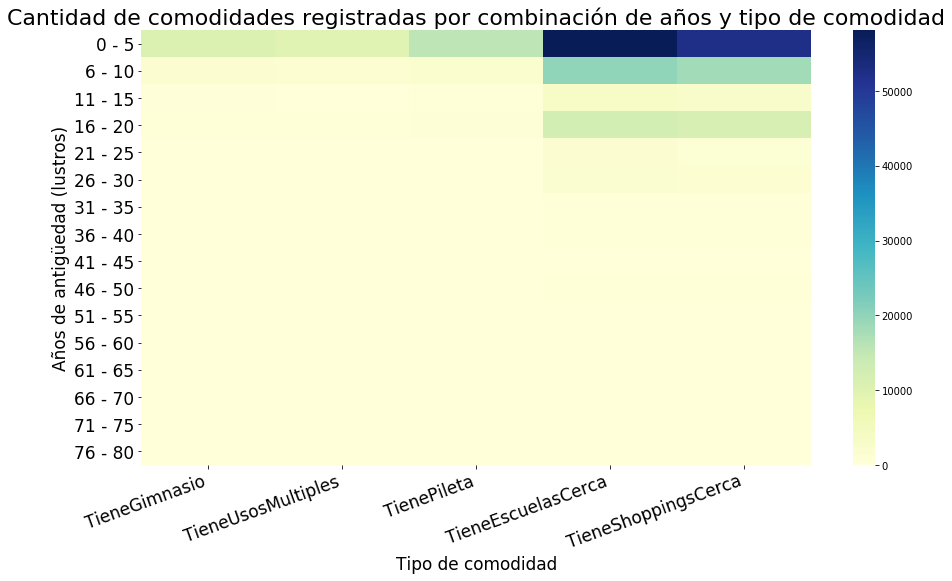

In [53]:
plt.figure(figsize=(15,8))
plot = sb.heatmap(df_comodidad_agrupada5,cmap = 'YlGnBu', cbar = True)
plot.set_title('Cantidad de comodidades registradas por combinación de años y tipo de comodidad', \
               fontsize = 22, y=2)
plot.set_xlabel('Tipo de comodidad', fontsize = 17)
plot.set_ylabel('Años de antigüedad (lustros)', fontsize = 17)
plt.xticks(fontsize = 17, rotation = 20, ha = 'right')
plt.yticks(fontsize = 17)
plt.show()

Se ve que en las propiedades antiguas no hay suficiente cantidad de comodidades como para poder apreciarlas en el gráfico

In [54]:
# Si se toman propiedades con hasta 20 años de antigüedad se tiene lo siguiente
df_comodidad_agrupada5[0:4]

,TieneGimnasio,TieneUsosMultiples,TienePileta,TieneEscuelasCerca,TieneShoppingsCerca
RangoDeAños,,,,,
0 - 5,10782.0,9652.0,15573.0,58159.0,52386.0
6 - 10,1659.0,1498.0,2236.0,20149.0,18271.0
11 - 15,314.0,218.0,457.0,3610.0,2841.0
16 - 20,544.0,671.0,697.0,12406.0,11514.0


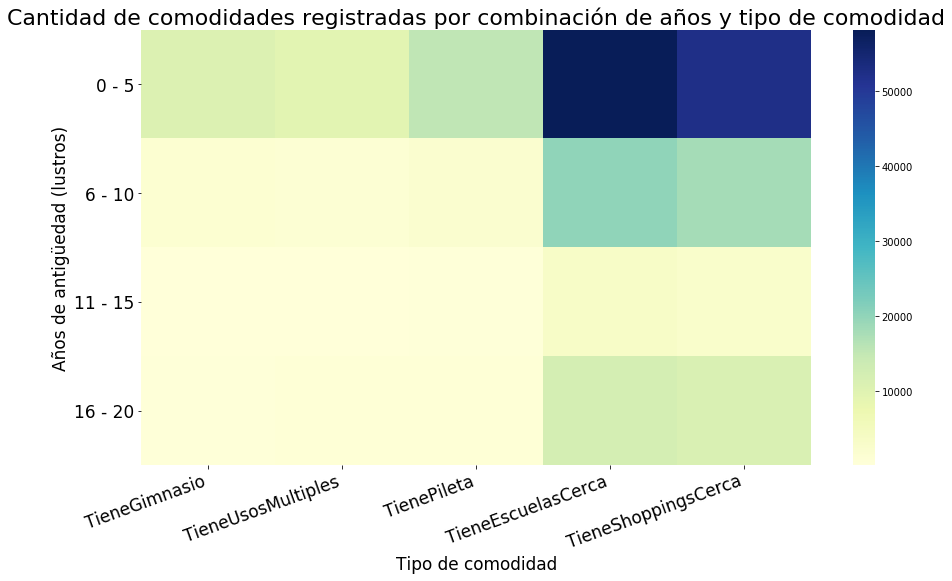

In [55]:
plt.figure(figsize=(15,8))
plot = sb.heatmap(df_comodidad_agrupada5[0:4], cmap = 'YlGnBu', cbar = True, annot = False)
plot.set_title('Cantidad de comodidades registradas por combinación de años y tipo de comodidad', \
               fontsize = 22, y=2)
plot.set_xlabel('Tipo de comodidad', fontsize = 17)
plot.set_ylabel('Años de antigüedad (lustros)', fontsize = 17)
plt.xticks(fontsize = 17, rotation = 20, ha = 'right')
plt.yticks(fontsize = 17, rotation = 0)
plt.show()

Se ve que hay una diferencia notoria en la proporción de comodidades compartidas respecto de las propias de las propiedades. Para visualizar puede ser conveniente hacer una distinción.

In [56]:
# Si se descartan las columnas TieneEscuelasCerca y TieneShoppingsCerca se tiene
df_comodidad_agrupada5[['TieneGimnasio', 'TieneUsosMultiples', 'TienePileta']][0:4]

,TieneGimnasio,TieneUsosMultiples,TienePileta
RangoDeAños,,,
0 - 5,10782.0,9652.0,15573.0
6 - 10,1659.0,1498.0,2236.0
11 - 15,314.0,218.0,457.0
16 - 20,544.0,671.0,697.0


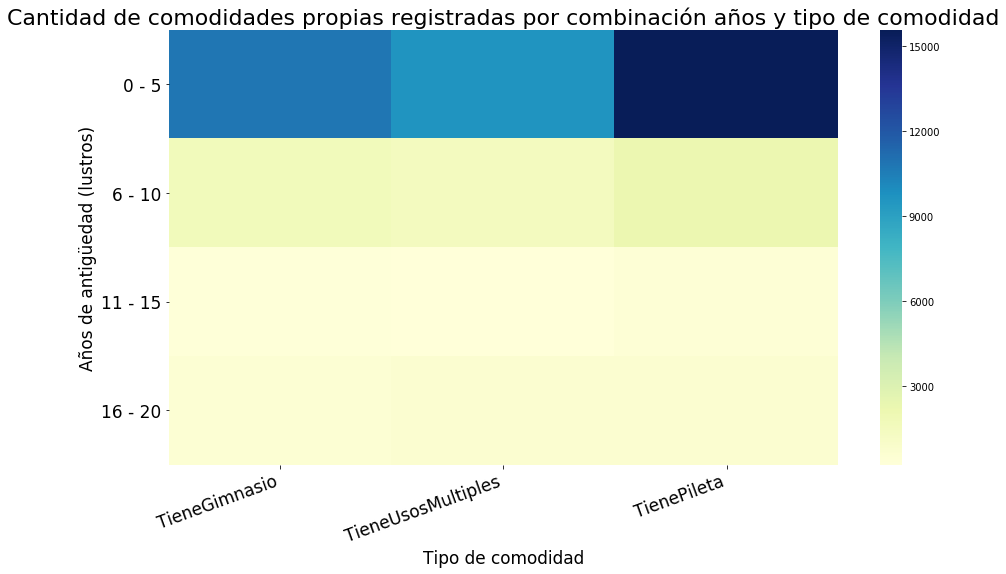

In [57]:
plt.figure(figsize=(15,8))
plot = sb.heatmap(df_comodidad_agrupada5[['TieneGimnasio', 'TieneUsosMultiples', 'TienePileta']][0:4], \
                  cmap = 'YlGnBu', cbar = True)
plot.set_title('Cantidad de comodidades propias registradas por combinación años y tipo de comodidad', \
               fontsize = 22, y=2)
plot.set_xlabel('Tipo de comodidad', fontsize = 17)
plot.set_ylabel('Años de antigüedad (lustros)', fontsize = 17)
plt.xticks(fontsize = 17, rotation = 20, ha = 'right')
plt.yticks(fontsize = 17, rotation = 0)
plt.show()

In [58]:
# Ahora se agrupa por años de antigüedad
df_comodidad_agrupada = df_comodidad\
    .groupby('Antiguedad')\
    .agg({'TieneGimnasio':'sum', \
          'TieneUsosMultiples':'sum', \
          'TienePileta':'sum', \
          'TieneEscuelasCerca':'sum', \
          'TieneShoppingsCerca':'sum'})\
    .copy()

In [59]:
df_comodidad_agrupada.head(10)

,TieneGimnasio,TieneUsosMultiples,TienePileta,TieneEscuelasCerca,TieneShoppingsCerca
Antiguedad,,,,,
0,4400.0,4567.0,6683.0,23777.0,20727.0
1,1311.0,855.0,1974.0,5716.0,4491.0
2,616.0,498.0,904.0,2613.0,2370.0
3,701.0,650.0,1013.0,3068.0,2850.0
4,935.0,818.0,1296.0,4301.0,4056.0
5,2819.0,2264.0,3703.0,18684.0,17892.0
6,280.0,138.0,299.0,1314.0,954.0
7,98.0,102.0,171.0,937.0,790.0
8,85.0,93.0,174.0,1133.0,906.0


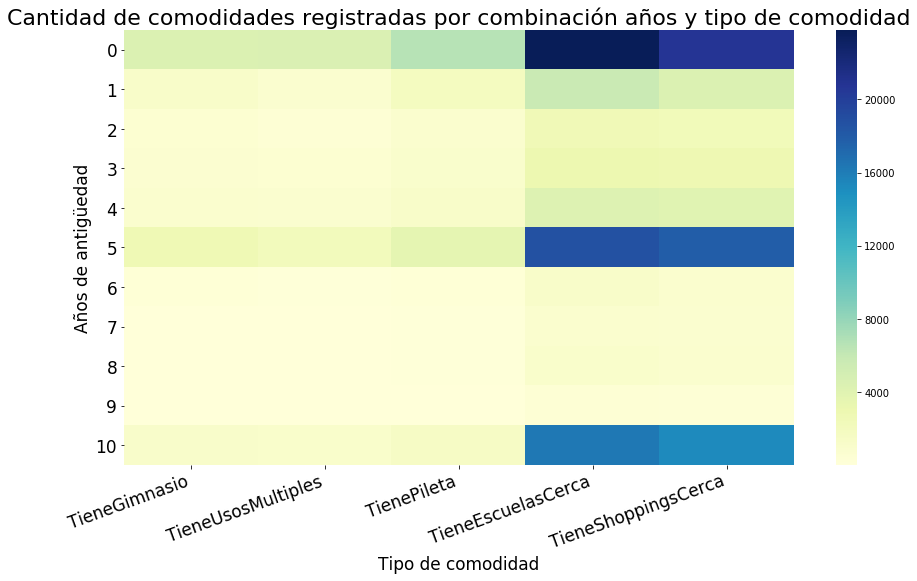

In [60]:
# Se visualiza un heatmap con 10 años de antigüedad
plt.figure(figsize=(15,8))
plot = sb.heatmap(df_comodidad_agrupada[0:11], cmap = 'YlGnBu', cbar = True)
plot.set_title('Cantidad de comodidades registradas por combinación años y tipo de comodidad', \
               fontsize = 22, y=2)
plot.set_xlabel('Tipo de comodidad', fontsize = 17)
plot.set_ylabel('Años de antigüedad', fontsize = 17)
plt.xticks(fontsize = 17, rotation = 20, ha = 'right')
plt.yticks(fontsize = 17, rotation = 0)
plt.show()

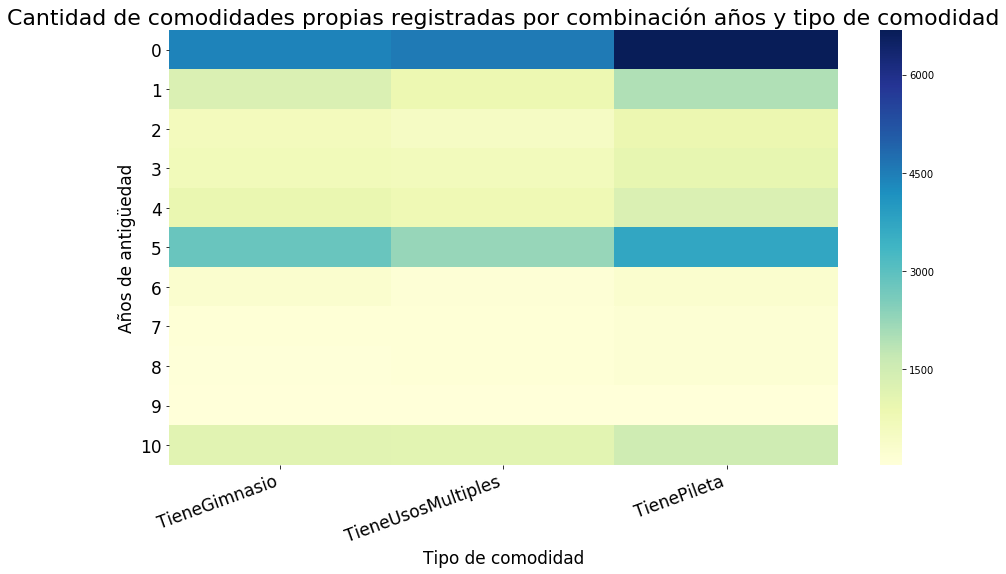

In [61]:
# Se visualiza un heatmap con 10 años de antigüedad
plt.figure(figsize=(15,8))
plot = sb.heatmap(df_comodidad_agrupada[['TieneGimnasio', 'TieneUsosMultiples', 'TienePileta']][0:11], cmap = 'YlGnBu', cbar = True)
plot.set_title('Cantidad de comodidades propias registradas por combinación años y tipo de comodidad', \
               fontsize = 22, y=2)
plot.set_xlabel('Tipo de comodidad', fontsize = 17)
plot.set_ylabel('Años de antigüedad', fontsize = 17)
plt.xticks(fontsize = 17, rotation = 20, ha = 'right')
plt.yticks(fontsize = 17, rotation = 0)
plt.show()